# Прогнозирование заказов такси

**Описание данных:**
- num_orders - Количество заказов находится в столбце
- datetime - Временной ряд


**Структура проекта:**
 - Загрузите и  ресемплирование данных
 - Анализ данных
 - Обучение моделий : 
     - Условие - тестовая выборка должна составлять 10 % от исходных данных.
     - Условие - целевая метрика RMSE на тестовой выборке должна не превышить 48
 - Проверка на тестовой выборке
 - Выводы

# 1. Подготовка

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_score, TimeSeriesSplit , GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
!pip install catboost
from catboost import Pool, cv, CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [26]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/taxi.csv', index_col=[0], parse_dates=[0])
#parse_dates задает имена столбцов, которые будут преобразованы в тип DateTime

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [28]:
print(df.index.is_monotonic)#хронологический порядок дат соблюдён

True


In [29]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Text(0, 0.5, 'number of orders')

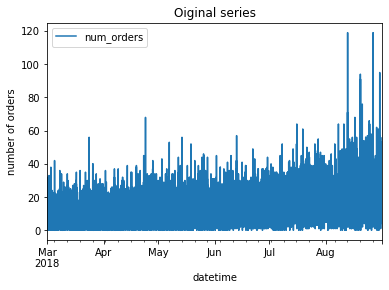

In [30]:
#график исходного ряда
df.plot()
plt.title('Oiginal series')
plt.ylabel("number of orders")

In [31]:
df = df.resample('1H').sum()#ресемплирование по одному часу

# 2. Анализ

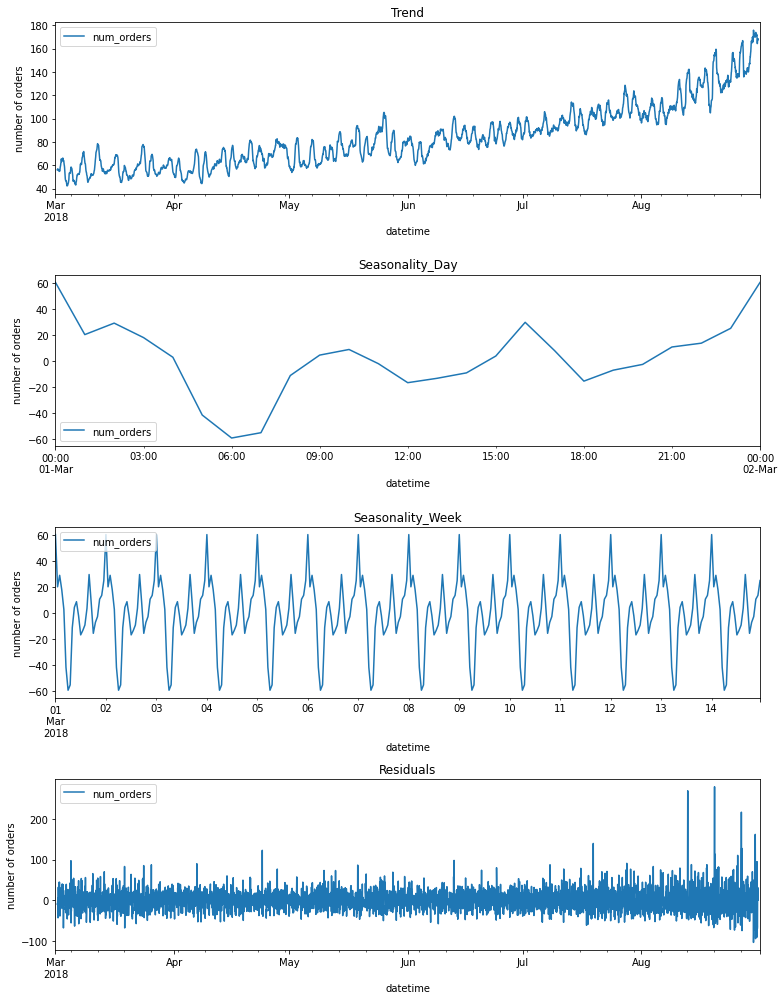

In [32]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(11, 14))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel("number of orders")

plt.subplot(412)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality_Day')
plt.ylabel("number of orders")

plt.subplot(413)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-14 23:59:59'].plot(ax=plt.gca())
plt.title('Seasonality_Week')
plt.ylabel("number of orders")


plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel("number of orders")


plt.tight_layout()

Text(0, 0.5, 'number of orders')

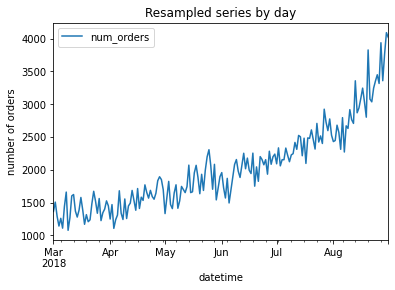

In [33]:
#график ряда после ресемплирования по дням
df.resample('1D').sum().plot()
plt.title('Resampled series by day')
plt.ylabel("number of orders")

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


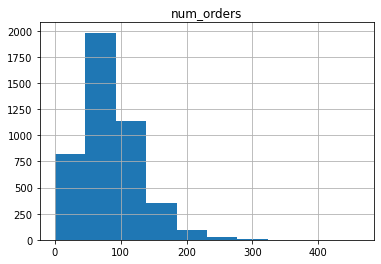

In [34]:
desc = df.describe()
df.hist()
desc

In [35]:
#посмотрим коэффициент вариации
# имеем небольшой разброс
# есть выбросы
# Удалять выбросы некорректно, так как перед нами временной ряд. Если выбросов много, стоит использовать сглаживание.

print('Var :', desc.loc['std']/desc.loc['mean'])

Var : num_orders    0.533314
dtype: float64


Судя по графикам, есть явный тренд на увеличение числа заказов. Также наблюдается сезонность с периодом в один день: в районе 6 утра число заказов минимально (в это время обычно меньше всего рейсов), а больше всего заказов ближе к полуночи (в это время прилетает много рейсов, и, видимо, неудобно добираться на другом транспорте).
Временной ряд не похож на стационарный: у него меняется среднее значение, есть ярко выраженный тренд.
Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, 
Что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. 
Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики 
(например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными.
Наш ряд как раз нестационарный
Один из вариантов разобраться, в чем она(нестационарность) -  это использовать критерий Критерий Дики-Фуллера и много ещё чего, а потом попробовать её стабилизировать за счет преоразования Бокса-Кокса, но, черт, я к такому пока не готов)
Воспользуемся тем, что я зная на данный момент.

In [36]:
#попробуем бороться с этим с помощью разности временного ряда
df_shift = df - df.shift()

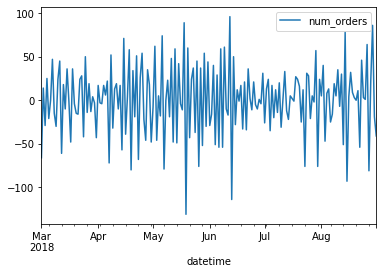

In [37]:
df_shift.resample('1D').sum().plot()
#Ряд из первых разностей уже больше похож на стационарный 
#если бы этого не произошло, стоило бы рассмотреть ряд из вторых-итд разностей). 

# 3. Обучение

In [38]:
#создадим признаки для работы модели
#так как наблюдается суточная сезонность, то значение max_lag имеет смысл брать не более 24
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 6)

In [39]:
#удалим строки с образовавшимися нулевыми значениями
df = df.dropna()

df.head()

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.333333
2018-03-02 01:00:00,120,1,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.166667
2018-03-02 02:00:00,75,2,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,84.666667
2018-03-02 03:00:00,64,3,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,87.000000
2018-03-02 04:00:00,20,4,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.666667


In [40]:
#разбитие данных

target = df['num_orders']
features = df.drop('num_orders', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
features, target, shuffle=False,  test_size=0.10, random_state=8888)

In [41]:
#кросс валидация
#для временных рядов нужно использовать разбиение TimeSeriesSplit
def CV_scor_Time(model):
    errors = []
    values = features_train.values

        # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=6) 

        # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = model
        model.fit(values[train], target_train[:len(train)])
        predict = model.predict(values[test])
        RMSE = mean_squared_error(target_train[test],predict)** 0.5
        errors.append(RMSE)

    print('Результаты модели по кросс валидации :', model)
    return np.mean(np.array(errors))
    errors.clear()

#по-хорошему все это нужно было соединить с GridSearchCV и подобрать параметры
# но, подбирал ручками)

In [50]:
%%time
#Wall time: 6.08 s
CV_scor_Time(lgb.LGBMRegressor(num_leaves=31, learning_rate=0.22, n_estimators=500, eval_metric = 'mse'))

Результаты модели по кросс валидации : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='mse', importance_type='split', learning_rate=0.22,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
CPU times: user 11.6 s, sys: 356 ms, total: 12 s
Wall time: 6.16 s


25.952787519040516

In [42]:
%%time
#Wall time: 14.9 s
CV_scor_Time(CatBoostRegressor(max_depth=6, n_estimators=500, random_state=12345, learning_rate=0.23, verbose = False))

Результаты модели по кросс валидации : <catboost.core.CatBoostRegressor object at 0x7f4bad0b82b0>
CPU times: user 26.1 s, sys: 1.75 s, total: 27.8 s
Wall time: 14.9 s


25.448395883643673

In [44]:
%%time
#Wall time: 54.2 ms
CV_scor_Time(LinearRegression())

Результаты модели по кросс валидации : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
CPU times: user 38 ms, sys: 28.2 ms, total: 66.2 ms
Wall time: 54.2 ms


26.839975855289342

# 4. Тестирование

In [45]:
#константная модель, предсказывающая предыдущее значение временного ряда.
pred_const = target_test.shift()
pred_const.iloc[0] = target_train.iloc[-1]
print("Результат константной модели RMSE:", mean_squared_error(target_test,pred_const)** 0.5)

Результат константной модели RMSE: 58.881776776551476


Результат модели  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)  RMSE: 45.83447405433365
Результат модели  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='mse', importance_type='split', learning_rate=0.22,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)  RMSE: 39.42807222659499
Результат модели  <catboost.core.CatBoostRegressor object at 0x7f4ba70f3470>  RMSE: 40.554772643702854
CPU times: user 21.9 s, sys: 816 ms, total: 22.7 s
Wall time: 11.8 s


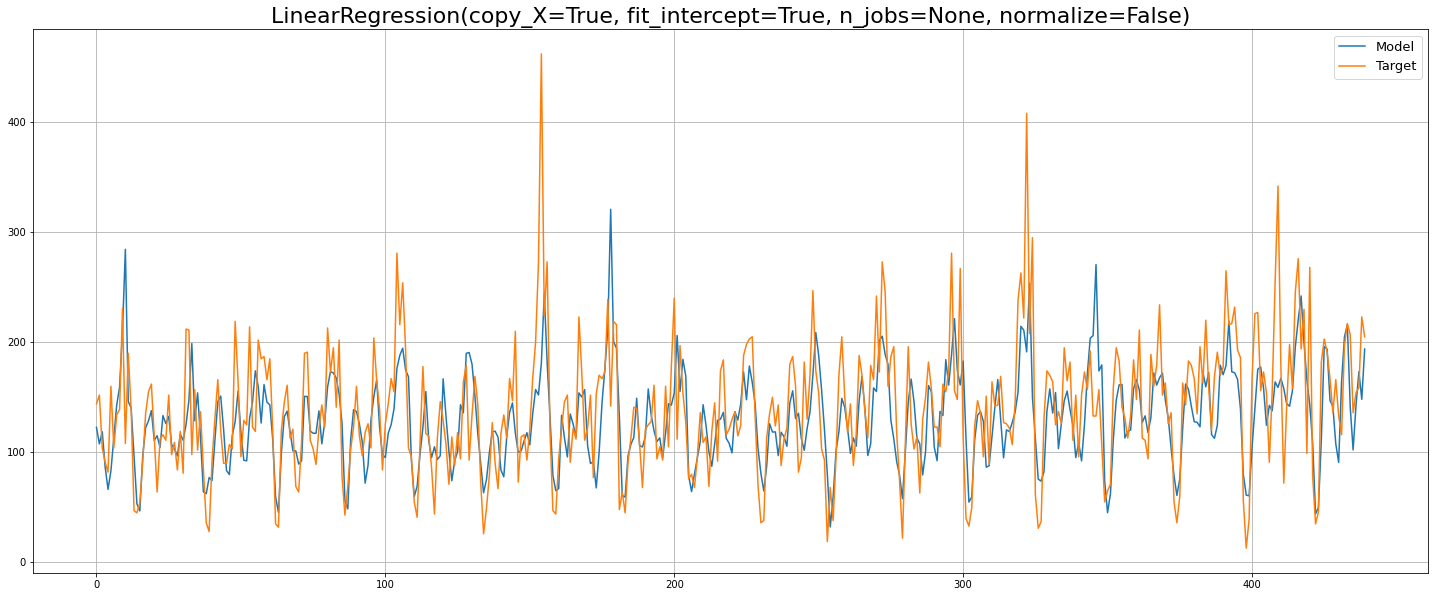

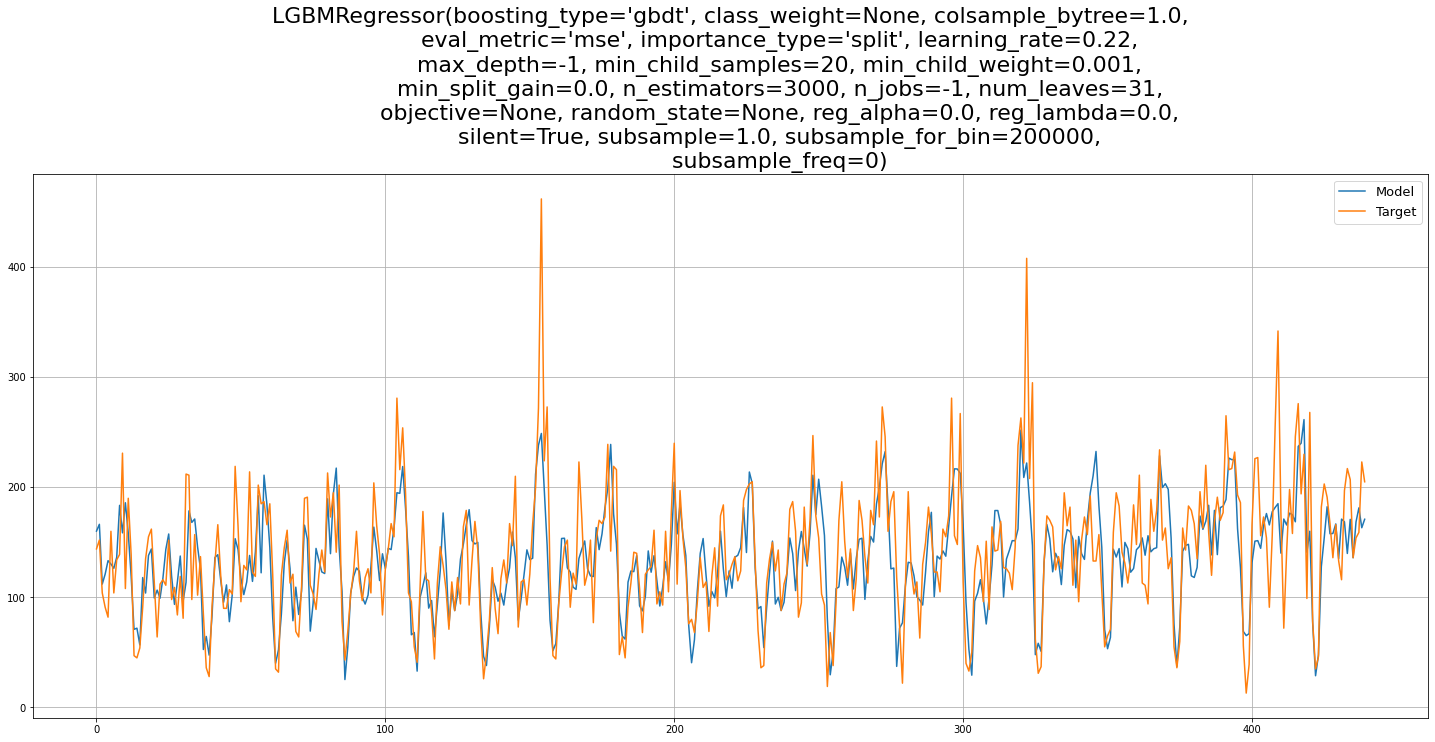

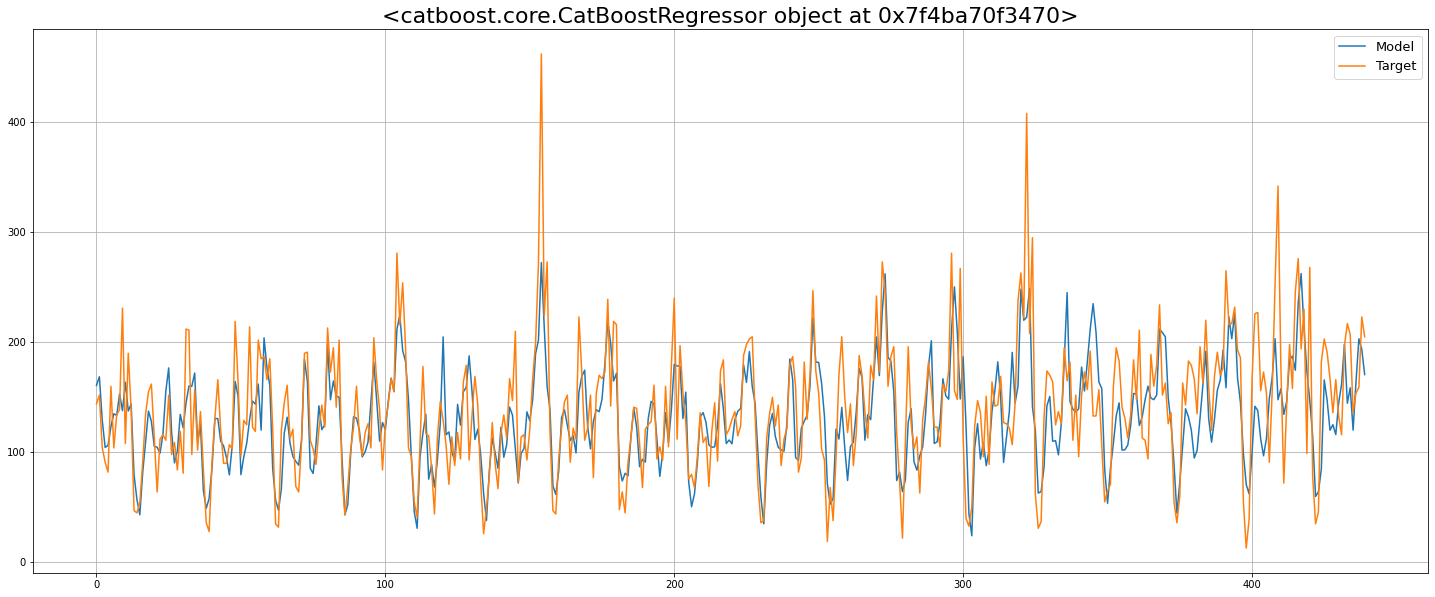

In [48]:
%%time
#Wall time: 4.75 s
#вывод результатов модели на тестовой выборке
def best_model(model):

    model = model
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    print("Результат модели ",model," RMSE:", mean_squared_error(target_test, pred)** 0.5)
    plt.figure(figsize=(25, 10))
    plt.plot(pred, label = "Model")
    plt.plot(target_test.values, label = "Target")
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)
    plt.title(model, fontsize=22)
    
    
best_model(LinearRegression())
best_model(lgb.LGBMRegressor(num_leaves=31,learning_rate=0.22,n_estimators=500,eval_metric = 'mse'))
best_model(CatBoostRegressor(max_depth=6, n_estimators=500, random_state=12345, learning_rate=0.23, verbose = False))

Лучшая метрика у модели LGBMRegressor, по графикам видно, что она неплохо справляется со стандартными значениями, но не может предсказать аномальные значения, например, три крупных пика по заказам. 
Кстати, что это за пики?

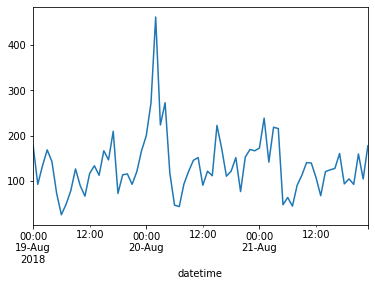

In [47]:
target_test['2018-08-19':'2018-08-21'].plot()
#что было в ночь на 20 августа? 
#День святого Иштвана в Венгрии?
#или отменили рейсы в аэропорту и все поехали обратно

Выводы:

Для прогнозирования заказов такси на следующий час было посторено три модели.
Решающим фактором по выбору основной модели была точность, поскольку иного не указывалось.
Хоть и удалось достигнуть точности по RMSE ниже 48, а именно 39.4 по модели LGBMRegressor, но она явно не является рабочей для бизнеса. Хотя лучше чем ничего или константная, её показатели равны 58.8. Ведь медианное значение по количеству заказанных такси в районе 78 машин в час. А у нас ошибка предсказания модели в 39.4 машины, это значительно для данных объемов. Радует, что причина такой ошибки в основном с проблемами модели в прогнозировании аномальных значений, думаю, что это можно исправить.  В любом случае решать заказчику.
